Import client code.

In [1]:
import logging
reload(logging) # This is required for ipython notebook
# The error is reported using logging module

<module 'logging' from 'D:\Anaconda2\lib\logging\__init__.pyc'>

In [2]:
import os, sys
sys.path.append('..')
import ue4cv

Connect to the game

In [3]:
def print_message(msg):
    print '.'

In [9]:
client = ue4cv.Client(('localhost', 9000), print_message)
if client.connect(): # Make sure unrealcv server can detect client disconnection
    print 'Client connected'
else:
    print 'Error, Can not connect to the game, make sure the game is running'
client.disconnect()

client = ue4cv.Client(('localhost', 9000), print_message)
print client.connect() 
client = ue4cv.Client(('localhost', 9000), print_message)
print client.connect() # Already connected, reject.
# print 'Client disconnect'

# If the client reference is lost, it should be gc-ed

ERROR:root:Can not connect to ('localhost', 9000)


Error, Can not connect to the game, make sure the game is running


error: [Errno 10057] A request to send or receive data was disallowed because the socket is not connected and (when sending on a datagram socket using a sendto call) no address was supplied

Exception in thread Thread-6:
Traceback (most recent call last):
  File "D:\Anaconda2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "D:\Anaconda2\lib\threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "..\ue4cv.py", line 144, in __receiving
    message = SocketMessage.ReceivePayload(self.socket)
  File "..\ue4cv.py", line 36, in ReceivePayload
    raw_magic = rfile.read(4)
  File "D:\Anaconda2\lib\socket.py", line 384, in read
    data = self._sock.recv(left)
error: [Errno 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond



In [12]:
print client.request('vset /mode/lit')
# client2.request('vset /mode/depth')

ERROR:root:Can not receive any respone from server after 5 seconds, timeout


None


Exception in thread Thread-7:
Traceback (most recent call last):
  File "D:\Anaconda2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "D:\Anaconda2\lib\threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "..\ue4cv.py", line 144, in __receiving
    message = SocketMessage.ReceivePayload(self.socket)
  File "..\ue4cv.py", line 36, in ReceivePayload
    raw_magic = rfile.read(4)
  File "D:\Anaconda2\lib\socket.py", line 384, in read
    data = self._sock.recv(left)
error: [Errno 10054] An existing connection was forcibly closed by the remote host



Define a function to read message from text file

In [3]:
def read_camera_info(filename):
    with open(filename) as f:
        lines = f.readlines()
    # Parse camera location and rotation from file
    camera_pos = []
    for line_id in range(len(lines)):
        line = lines[line_id].strip() # Remove \n at the end
        if line_id % 3 == 0: # filename
            pass
        elif line_id % 3 == 1: # location
            location = [float(v) for v in line.split(' ')]
        elif line_id % 3 == 2: # Rotation
            rotation = [float(v) for v in line.split(' ')]
            camera_pos.append((location, rotation))
    return camera_pos

In [4]:
camera_pos = read_camera_info('./camera_info.txt')

Define a function to render images

In [5]:
import time
def render_frame(client, pos):
    loc = pos[0] # location
    rot = pos[1] # rotation
    cmd = 'vset /camera/0/location %.3f %.3f %.3f' % (loc[0], loc[1], loc[2])
    response = client.request(cmd)
    assert response == 'ok'
    cmd = 'vset /camera/0/rotation %.3f %.3f %.3f' % (rot[0], rot[1], rot[2])
    response = client.request(cmd)
    assert response == 'ok'
    files = []
    f1 = client.request('vget /camera/0/lit')
    f2 = client.request('vget /camera/0/depth')
    f3 = client.request('vget /camera/0/object_mask')
    f4 = client.request('vget /camera/0/normal')

    return [f1, f2, f3, f4]

Receive payload size 4
Receive payload size 4
Receive payload size 85
Receive payload size 85
Receive payload size 85
Receive payload size 85


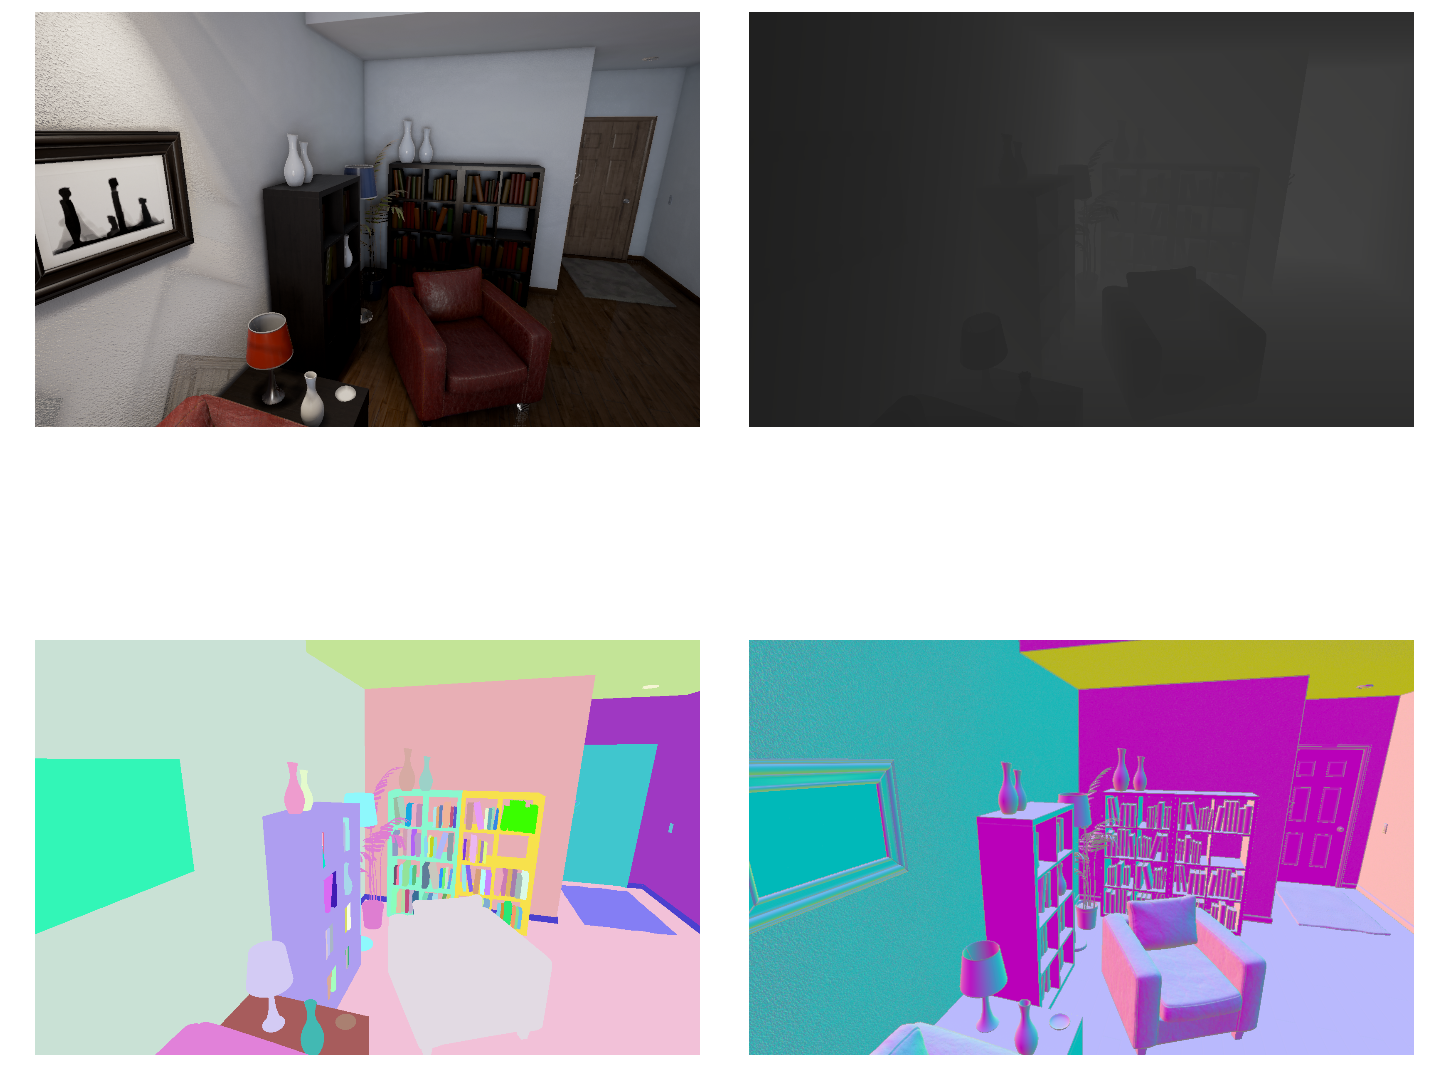

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)

pos = camera_pos[1]
files = render_frame(client, pos)
N = len(files)
for i in range(N):
    plt.subplot(N/2,2,i+1)
    im = plt.imread(files[i])
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

In [8]:
objects = client.request('vget /objects').split(' ')
print objects[:5]

Receive payload size 3490
['Carpet_5', 'SM_CoffeeTable_14', 'Couch_13', 'SM_Room_7', 'SM_Room_OuterShell_14']


In [9]:
objname = objects[0]
client.request('vget /object/%s/color' % objname)

Receive payload size 23


'(R=57,G=2,B=34,A=255)'

In [12]:
print client.request('vrun ls')

Receive payload size 698
vrun [str]
Run an alias for Unreal CV plugin
vget /camera/[uint]/location
Get camera location
vget /camera/[uint]/rotation
Get camera rotation
vset /camera/[uint]/location [float] [float] [float]
Set camera location
vset /camera/[uint]/rotation [float] [float] [float]
Set camera rotation
vget /camera/[uint]/view
Get snapshot from camera
vget /camera/[uint]/[str]
Get snapshot from camera
vset /mode/[str]
Set mode
vget /mode
Get mode
vget /objects
Get all objects in the scene
[str] /object/_/[str]
Get current object
vget /object/[str]/color
Get object color
vset /object/[str]/color
Set object color
vget /object/[str]/name
Get object name
vget /util/get_commands
Get all available commands

